### **Data cleaning**

Note: When lacking of packages, just use "!pip install ..."

In [2]:
import pandas as pd
#!pip install --upgrade llvmlite numba

import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
from esda.moran import Moran
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from zipfile import ZipFile
import os
import shutil
from mpl_toolkits.axes_grid1 import make_axes_locatable

import re

The urls that needed

In [3]:
night_economy_url = "https://data.london.gov.uk/download/london-night-time-economy/e554ddcd-4fb7-42dc-b0d2-d73f88938cdb/night-time-economy.xls"
late_night_liscenses_url = "https://data.london.gov.uk/download/alcohol-and-late-night-refreshment-licensing-statistics/7836522b-3b4c-4aae-9aa3-9b2389621a96/licensed-premises-24-hour.xlsx"
inside_airbnb_url = 'http://data.insideairbnb.com/united-kingdom/england/london/2022-12-10/visualisations/listings.csv'
land_url = 'https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/cc4e7e08-3071-488f-bdd9-a62cb1ed1c5c/land-area-population-density-london.xlsx'

Data cleaning for the **Night Time Economy** dataset

The dataset after cleaning should contain information about numbers of employees and workplaces in:
1. Cultural and leisure activities
2. Activities which support night time cultural and leisure activities
3. 24-hour health and personal social services
4. Activities which support wider social and economic activities
5. Any Night Time Economy category
6. Total in all sectors

In [4]:
# read in different data from different sheets
df_night_employee_all = pd.read_excel(night_economy_url, sheet_name='NTE employees London boroughs', skiprows=3)
df_night_workplace_all = pd.read_excel(night_economy_url, sheet_name='NTE businesses London boroughs', skiprows=3)

# set the columns names
column_names = ['Area code', 'Area name', 'Night Time Economy category'] + list(df_night_employee_all.columns[3:])
df_night_employee_all.columns = column_names
df_night_workplace_all.columns = column_names

# divide night time economy types to different columns
df_night_employee = df_night_employee_all.pivot_table(index=['Area code', 'Area name'], columns='Night Time Economy category', values=2017, aggfunc='first').reset_index()
df_night_workplace = df_night_workplace_all.pivot_table(index=['Area code', 'Area name'], columns='Night Time Economy category', values=2017, aggfunc='first').reset_index()

# delete all the rows not belonging to London boroughs
df_night_employee = df_night_employee[df_night_employee['Area code'].str.startswith('E09')]
df_night_workplace = df_night_workplace[df_night_workplace['Area code'].str.startswith('E09')]

# have a look at the dataframes
# df_night_employee.head()
df_night_workplace.head()

Night Time Economy category,Area code,Area name,24-hour health and personal social services,Activities which support night time cultural and leisure activities,Activities which support wider social and economic activities,Any Night Time Economy category,Cultural and leisure activities,Total in all sectors
0,E09000001,City of London,140.0,165.0,815.0,2940.0,1825.0,26835.0
1,E09000002,Barking and Dagenham,355.0,265.0,775.0,1985.0,590.0,7955.0
2,E09000003,Barnet,555.0,570.0,1495.0,4345.0,1720.0,24545.0
3,E09000004,Bexley,360.0,310.0,640.0,2045.0,740.0,9950.0
4,E09000005,Brent,355.0,595.0,1435.0,3715.0,1330.0,16230.0


Data cleaning for the **Late Night Freshment Liscenses** dataset

The dataset after cleaning should contain information about:
1. Number of 24-shops liscenses

In [5]:
# read in the data
df_24hour_store_all = pd.read_excel(late_night_liscenses_url, sheet_name='2017', skiprows=2, na_values = ':')

# set the columns names
column_names = ['Licensing authority', 'All total', 'Pubs, bars and nightclubs'] + list(df_24hour_store_all.columns[3:])
df_24hour_store_all.columns = column_names

# select specific column and drop rows not belonging to London boroughs
df_24hour_store = df_24hour_store_all[['Licensing authority', 'Total']].iloc[:33, [0, 1]]

# have a look at the dataframe
df_24hour_store.head()

,Licensing authority,Total
0,Barking and Dagenham,1.0
1,Barnet,0.0
2,Bexley,1.0
3,Brent,34.0
4,Bromley,8.0


Data cleaning and summary for the **Inside Airbnb** dataset <br>
**Note:** This chunck takes a little more time to load due to large file

The dataset after cleaning should contain information about: 
1. Numbers of different room types in differernt boroughs
2. Mean prices of airbnb in different boroughs

In [6]:
# read in the data
airbnb_origin = pd.read_csv(inside_airbnb_url)

# calculate the counts for different room types in different boroughs
df_airbnb = airbnb_origin.pivot_table(index='neighbourhood', columns='room_type', values='id', aggfunc='count', fill_value=0).reset_index()

# calculate the mean prices in different boroughs
average_price = airbnb_origin.groupby('neighbourhood')['price'].mean().reset_index()
average_price.columns = ['neighbourhood', 'average price']

# left join
df_airbnb = pd.merge(df_airbnb, average_price, on='neighbourhood', how='left')
df_airbnb['Sum_room'] = df_airbnb[['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']].sum(axis=1)

# have a look at the dataframe
df_airbnb.columns

Index(['neighbourhood', 'Entire home/apt', 'Hotel room', 'Private room',
       'Shared room', 'average price', 'Sum_room'],
      dtype='object')

Data cleaning for the land dataset:

The dataset after cleaning should contain information about: 
1. Area of different boroughs

In [7]:
df_land_all = pd.read_excel(land_url, sheet_name='Borough', skiprows=1, na_values = '')

# delete all the rows not belonging to London boroughs
df_land = df_land_all[['Code', 'Area name', 'Total Area (Hectares)']].iloc[:34]
#df_land = df_land[df_land_all['Code'].str.startswith('E09')]

df_land.columns

/opt/homebrew/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Index(['Code', 'Area name', 'Total Area (Hectares)'], dtype='object')

### **Correlation Matrix (Pearson)**

Merge all datasets into **one**

In [8]:
df_night = pd.merge(df_airbnb, df_24hour_store, left_on='neighbourhood', right_on='Licensing authority', how='left')
df_night = df_night.rename(columns={'Total': '24h_shop_liscense'}).drop(columns='Licensing authority')

df_night_economy = pd.merge(df_night_employee, df_night_workplace, on='Area name', how='left', suffixes=('_employee', '_workplace'))
df_night = pd.merge(df_night, df_night_economy, left_on='neighbourhood', right_on='Area name', how='left')
df_night = df_night.rename(columns={'Area code_employee': 'Area code'}).drop(columns='Area code_workplace')

df_night = pd.merge(df_night, df_land, left_on='neighbourhood', right_on='Area name', how='left')

df_night['airbnb density'] = df_night['Sum_room'] / df_night['Total Area (Hectares)']

df_night.columns

Index(['neighbourhood', 'Entire home/apt', 'Hotel room', 'Private room',
       'Shared room', 'average price', 'Sum_room', '24h_shop_liscense',
       'Area code', 'Area name_x',
       '24-hour health and personal social services_employee',
       'Activities which support night time cultural and leisure activities_employee',
       'Activities which support wider social and economic activities_employee',
       'Any Night Time Economy category_employee',
       'Cultural and leisure activities_employee',
       'Total in all sectors_employee',
       '24-hour health and personal social services_workplace',
       'Activities which support night time cultural and leisure activities_workplace',
       'Activities which support wider social and economic activities_workplace',
       'Any Night Time Economy category_workplace',
       'Cultural and leisure activities_workplace',
       'Total in all sectors_workplace', 'Code', 'Area name_y',
       'Total Area (Hectares)', 'airbnb densi

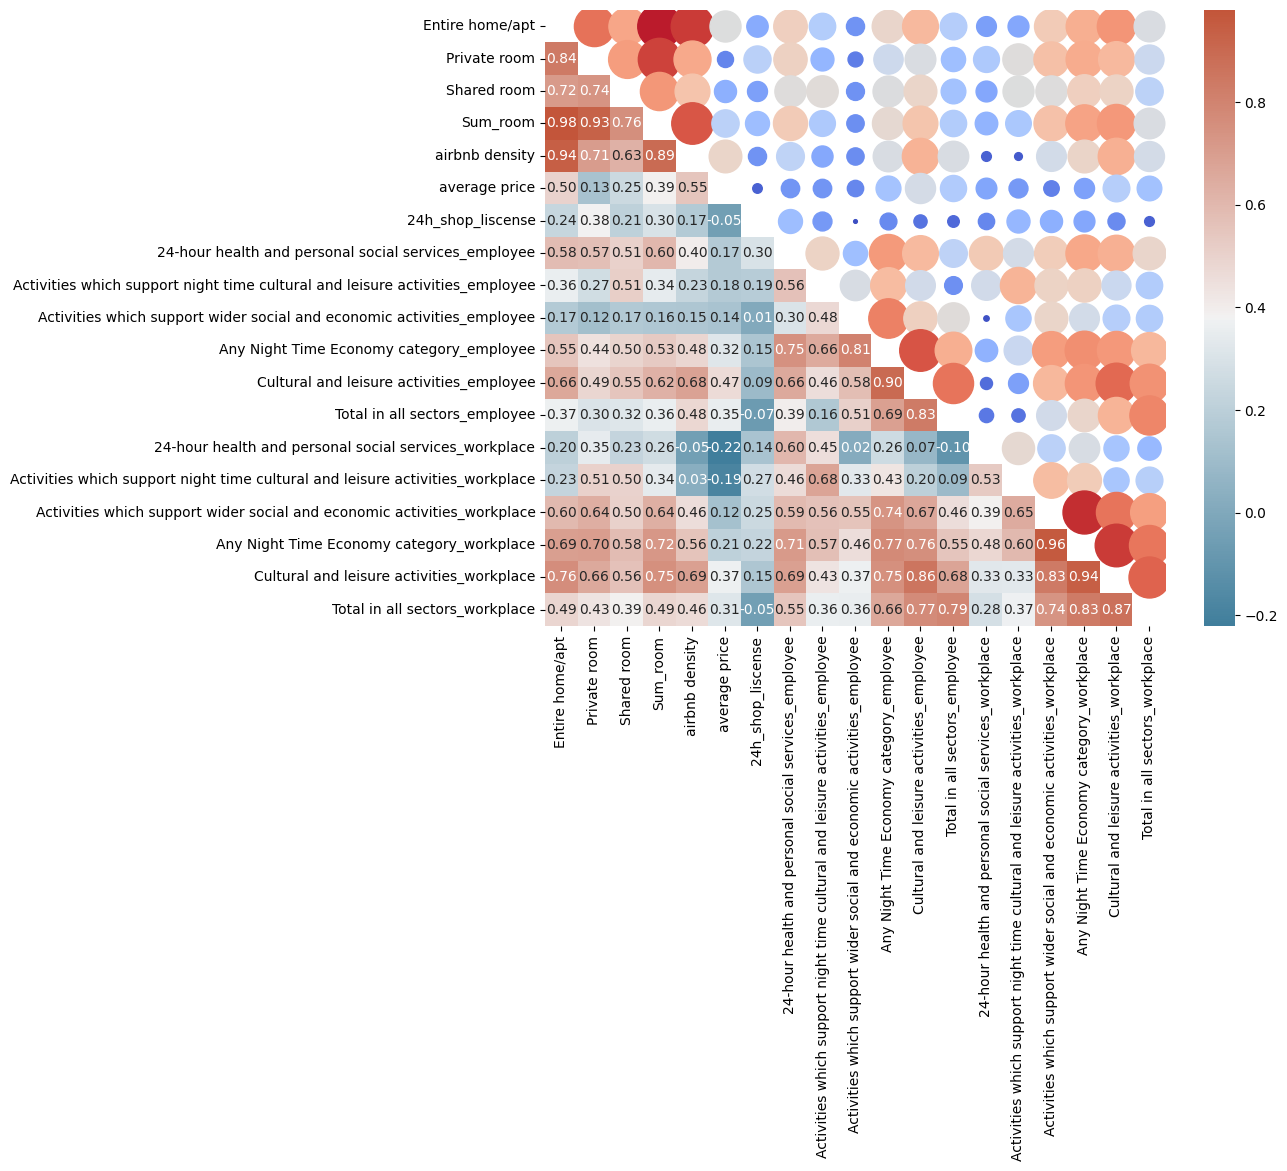

In [9]:
df_night_clean = df_night.dropna()
corr = df_night_clean[['Entire home/apt', 'Private room', 'Shared room', 'Sum_room', 'airbnb density',
                       'average price', '24h_shop_liscense', '24-hour health and personal social services_employee',
                       'Activities which support night time cultural and leisure activities_employee',
                       'Activities which support wider social and economic activities_employee',
                       'Any Night Time Economy category_employee', 'Cultural and leisure activities_employee',
                       'Total in all sectors_employee', '24-hour health and personal social services_workplace',
                       'Activities which support night time cultural and leisure activities_workplace',
                       'Activities which support wider social and economic activities_workplace',
                       'Any Night Time Economy category_workplace', 'Cultural and leisure activities_workplace',
                       'Total in all sectors_workplace']].corr()

# create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool))

# create a custom diverging palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f")

# add circles with size and color proportional to the absolute correlation
for i in range(len(corr.columns)):
    for j in range(i):
        if not mask[i, j]:
            value = np.abs(corr.iloc[i, j])
            size = value * 1000  # Set the size based on the absolute correlation
            color = value  # Set the color based on the absolute correlation
            plt.scatter(i + 0.5, j + 0.5, s=size, c=color, cmap='coolwarm', marker='o', vmin=0, vmax=1)

plt.show()

#### Check field information

Check the distribution of Airbnb related fields and night economy related fields with strong correlation in correlation analysis.

It is expected to include:
Basic statistics for each variable, such as mean, median, minimum, and maximum.
Plot the distribution of each variable, such as a histogram or box diagram.

       Entire home/apt  Private room  Shared room     Sum_room  \
count        31.000000     31.000000    31.000000    31.000000   
mean       1128.741935    787.967742    10.645161  1932.548387   
std        1097.908283    619.273794     8.428319  1664.164632   
min         136.000000     51.000000     0.000000   289.000000   
25%         285.500000    321.500000     4.000000   622.500000   
50%         753.000000    637.000000     8.000000  1411.000000   
75%        1662.000000    988.000000    13.500000  2681.000000   
max        3885.000000   2699.000000    34.000000  5891.000000   

       24-hour health and personal social services_employee  \
count                                          31.000000      
mean                                        11074.193548      
std                                          6209.829184      
min                                          3800.000000      
25%                                          7400.000000      
50%                        

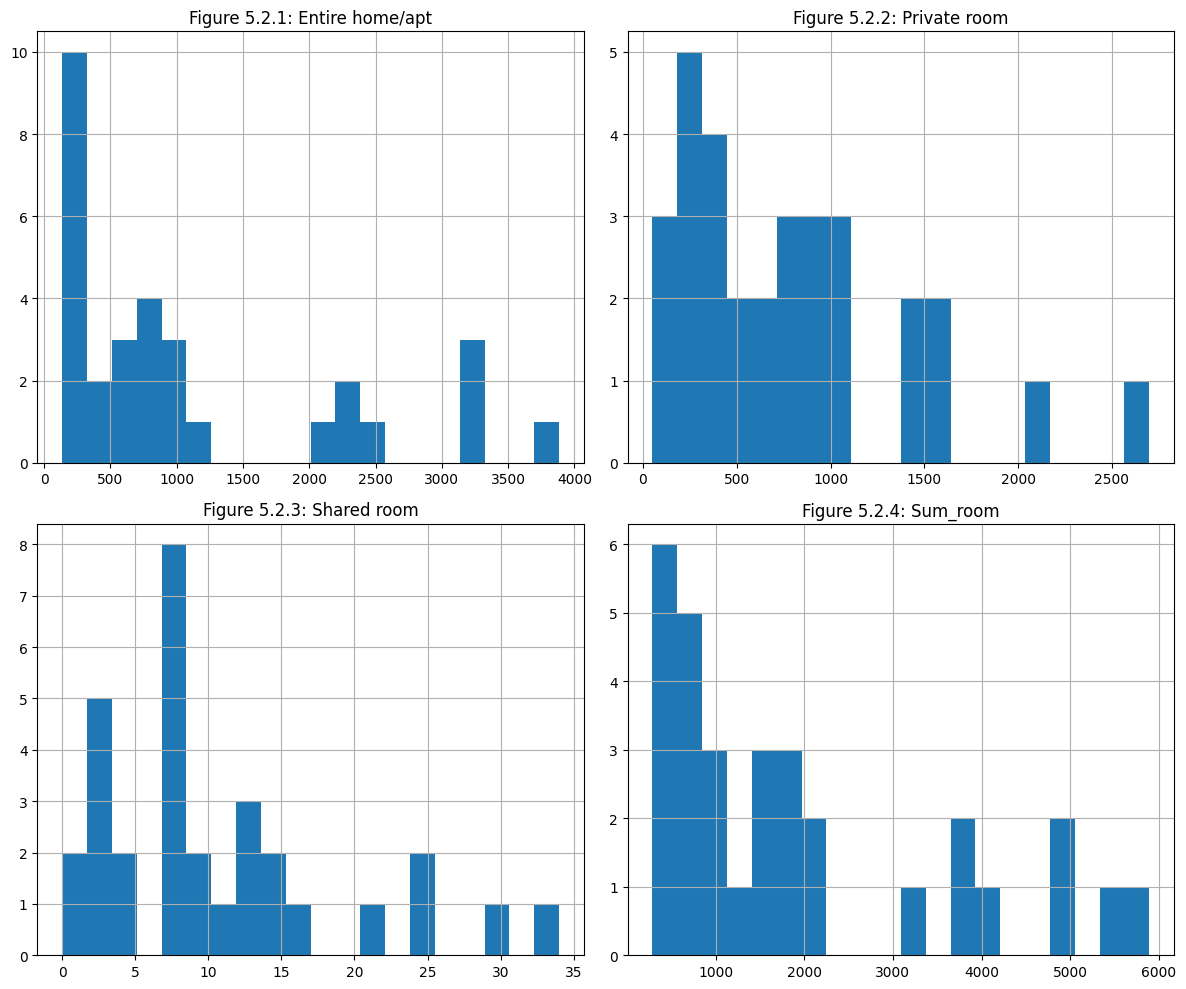

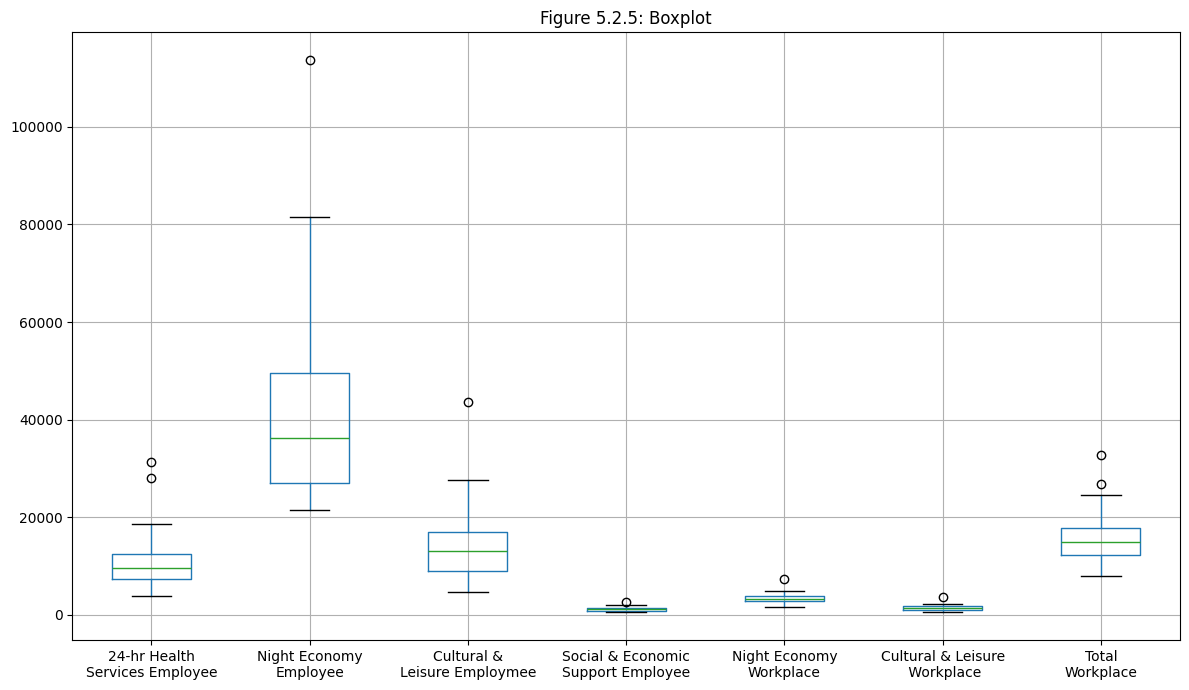

In [76]:
stats = df_night_clean[['Entire home/apt', 'Private room', 'Shared room', 'Sum_room',
            'airbnb density', '24-hour health and personal social services_employee',
            'Any Night Time Economy category_employee',
            'Cultural and leisure activities_employee',
            'Activities which support wider social and economic activities_workplace',
            'Any Night Time Economy category_workplace',
            'Cultural and leisure activities_workplace',
            'Total in all sectors_workplace']].describe()

print(stats)

columns = ['Entire home/apt', 'Private room', 'Shared room', 'Sum_room']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

axes = axes.flatten()

for i, column in enumerate(columns):
    subplot_number = i + 1  
    df_night_clean[column].hist(bins=20, ax=axes[i])
    axes[i].set_title(f"Figure 5.2.{subplot_number}: {column}")

plt.tight_layout()
plt.show()


columns = ['24-hour health and personal social services_employee',
           'Any Night Time Economy category_employee',
           'Cultural and leisure activities_employee',
           'Activities which support wider social and economic activities_workplace',
           'Any Night Time Economy category_workplace',
           'Cultural and leisure activities_workplace',
           'Total in all sectors_workplace']

short_labels = ['24-hr Health\nServices Employee',
                'Night Economy\nEmployee',
                'Cultural &\nLeisure Employmee',
                'Social & Economic\nSupport Employee',
                'Night Economy\nWorkplace',
                'Cultural & Leisure\n Workplace',
                'Total\nWorkplace']

fig, ax = plt.subplots(figsize=(12, 7))
boxplot = df_night_clean[columns].boxplot(ax=ax)

ax.set_xticklabels(short_labels, fontsize=10)

plt.title("Figure 5.2.5: Boxplot")

plt.tight_layout()
plt.show()


### **Spatial Autocorrelation Analysis （Moran's I）**

Download the **shapfile** of London boroughs to add geo-information

In [78]:
geo_url = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip'
response = requests.get(geo_url)

# create a temporary file folder
temp_folder = 'temp_geo_data'
os.makedirs(temp_folder, exist_ok=True)

# unzip files to the temporary file folder
with ZipFile(BytesIO(response.content)) as zip_file:
    zip_file.extractall(temp_folder)

all_files = []
for root, dirs, files in os.walk(temp_folder):
    for file in files:
        all_files.append(os.path.join(root, file))

# look for shapefile
shp_files = [file for file in all_files if file.endswith('.shp')]

# select shapefile
if shp_files:
    selected_shp_file = shp_files[0]
    gdf_boroughs = gpd.read_file(selected_shp_file)
    print(gdf_boroughs.head())
else:
    print("No SHP files found in the ZIP archive.")

# delete the temporary folder
shutil.rmtree(temp_folder)


Take the column 'Entire home/apt' as an example, do the **Moran's I and it's P value**  

Adding the results to dataframe  

Change the content of **variables** to change output map

Transform the dataframe to **geodataframe**, and visualize the result on maps

In [ ]:
# Merge Airbnb data
gdf_boroughs = gdf_boroughs.merge(df_night, left_on='NAME', right_on='neighbourhood', how='left')

print(gdf_boroughs.columns)

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry', 'neighbourhood', 'Entire home/apt',
       'Hotel room', 'Private room', 'Shared room', 'average price',
       'Sum_room', '24h_shop_liscense', 'Area code', 'Area name_x',
       '24-hour health and personal social services_employee',
       'Activities which support night time cultural and leisure activities_employee',
       'Activities which support wider social and economic activities_employee',
       'Any Night Time Economy category_employee',
       'Cultural and leisure activities_employee',
       'Total in all sectors_employee',
       '24-hour health and personal social services_workplace',
       'Activities which support night time cultural and leisure activities_workplace',
       'Activities which support wider social and economic activities_workplace',
       'Any Night Time Economy category_workplace',
       'Cultural and leisure activities_workplace',
       

Global Moran's I for Entire home/apt: 0.2930447997445552, P-value: 0.005


/var/folders/t6/2l4skldj33v76fg1nxfgvs7c0000gn/T/ipykernel_44943/3235130471.py:24: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_boroughs)


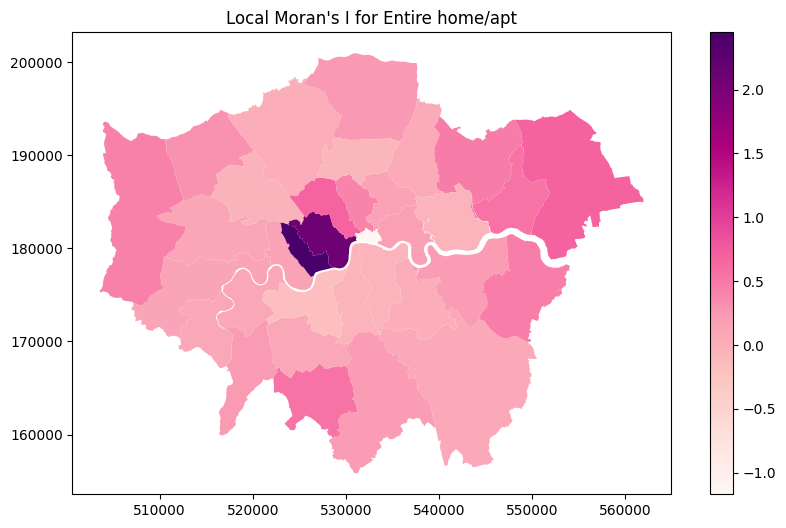

Global Moran's I for Private room: 0.14849444169608156, P-value: 0.069


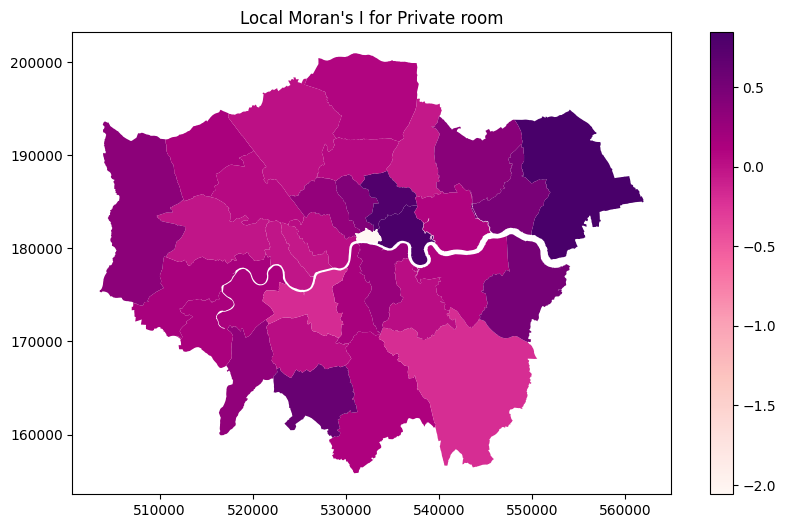

Global Moran's I for Shared room: 0.15503914865460963, P-value: 0.052


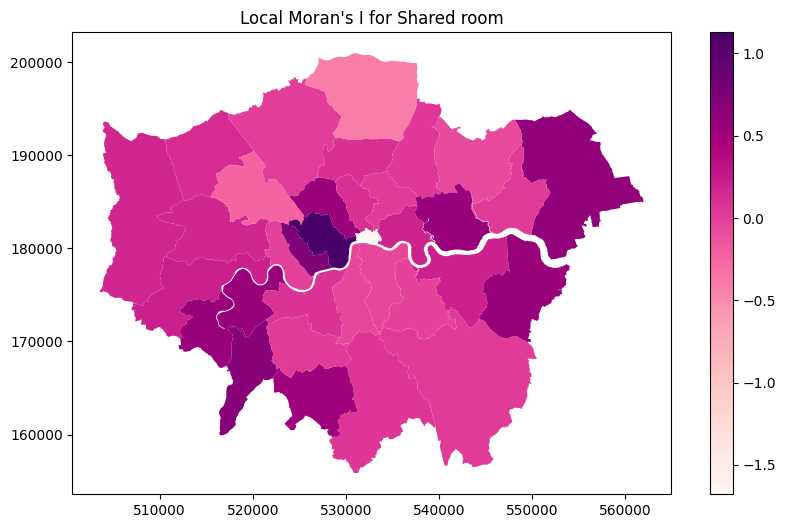

Global Moran's I for Sum_room: 0.2436275812996842, P-value: 0.02


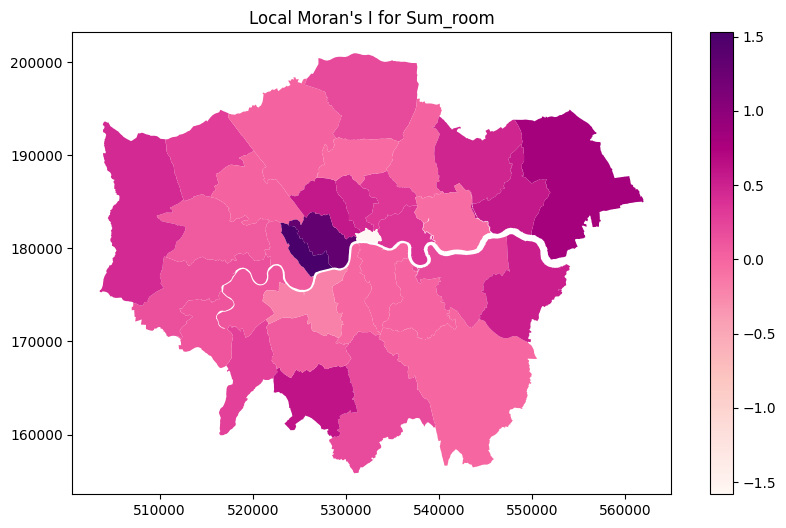

Global Moran's I for airbnb density: 0.4399559605304547, P-value: 0.001


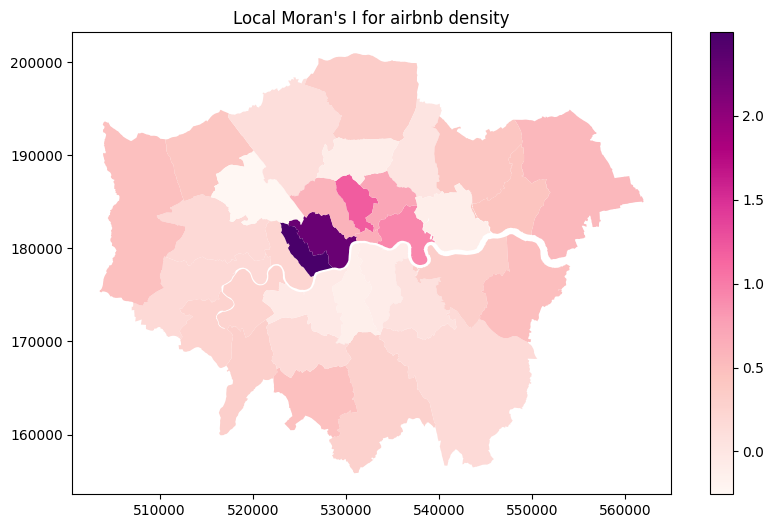

Global Moran's I for 24-hour health and personal social services_employee: 0.12684250148596438, P-value: 0.09


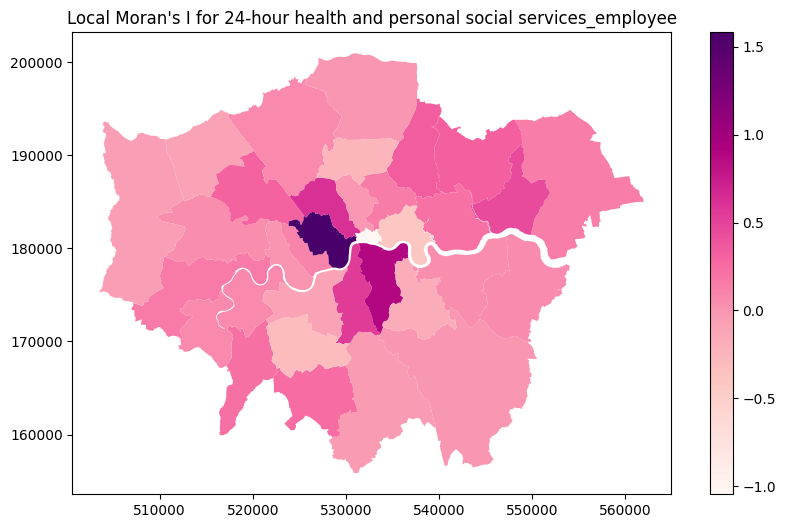

Global Moran's I for Any Night Time Economy category_employee: 0.21266237498247992, P-value: 0.012


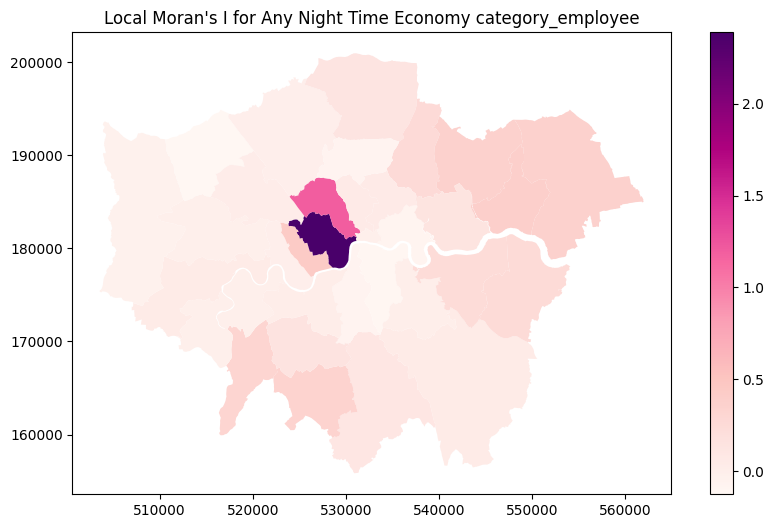

Global Moran's I for Cultural and leisure activities_employee: 0.22696707795609206, P-value: 0.002


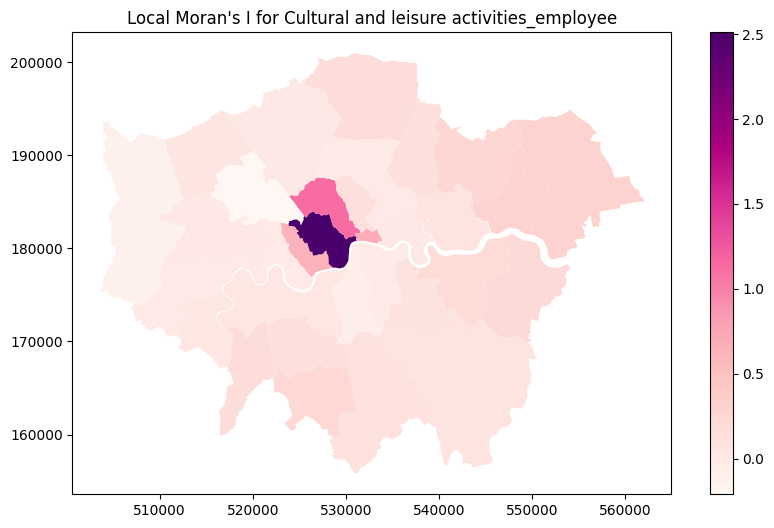

Global Moran's I for Activities which support wider social and economic activities_workplace: 0.19796501972890576, P-value: 0.019


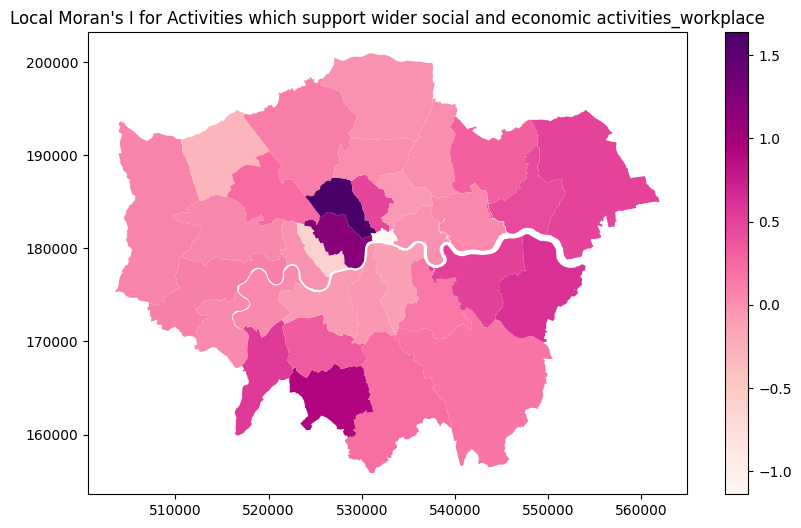

Global Moran's I for Any Night Time Economy category_workplace: 0.18133886687289313, P-value: 0.027


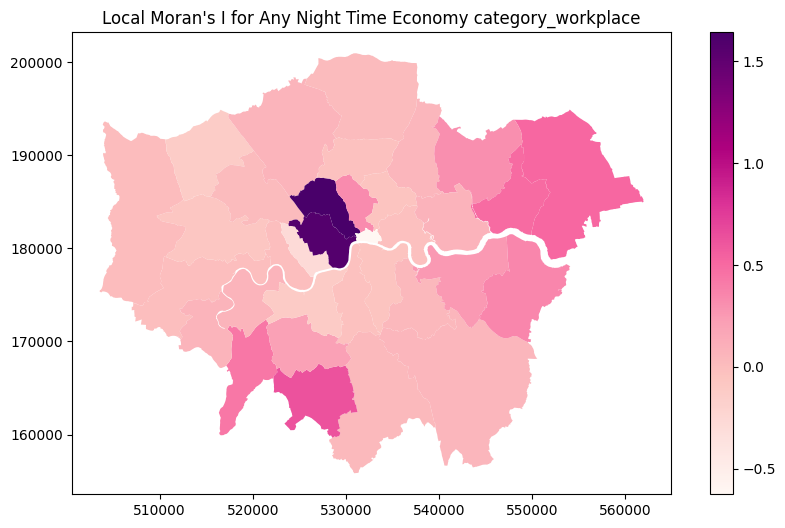

Global Moran's I for Cultural and leisure activities_workplace: 0.25625604542919067, P-value: 0.006


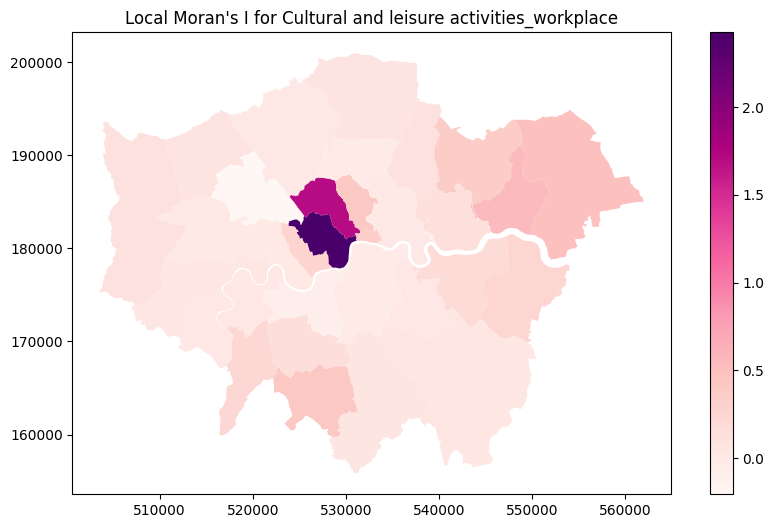

Global Moran's I for Total in all sectors_workplace: 0.3037748476769953, P-value: 0.002


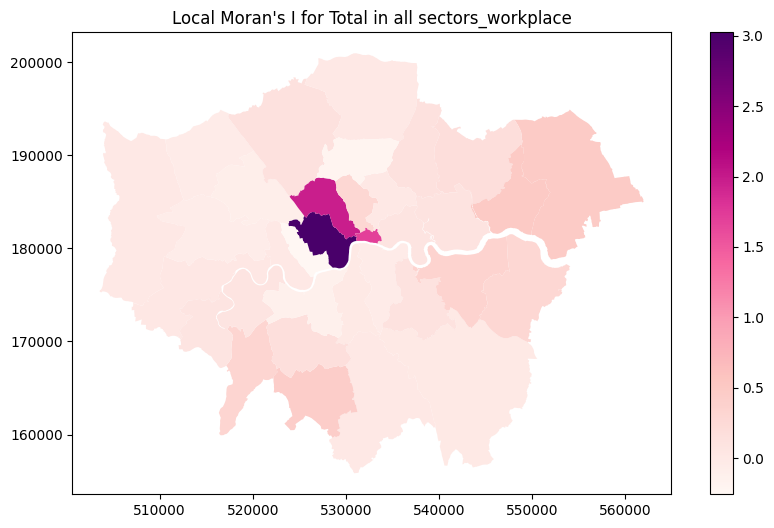

In [ ]:
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
import matplotlib.pyplot as plt

variables_to_analyze = [
    'Entire home/apt',
    'Private room',
    'Shared room',
    'Sum_room',
    'airbnb density',
    '24-hour health and personal social services_employee',
    'Any Night Time Economy category_employee',
    'Cultural and leisure activities_employee',
    'Activities which support wider social and economic activities_workplace',
    'Any Night Time Economy category_workplace',
    'Cultural and leisure activities_workplace',
    'Total in all sectors_workplace'
  
]

gdf_boroughs['airbnb density'] = pd.to_numeric(gdf_boroughs['airbnb density'], errors='coerce')

w = Queen.from_dataframe(gdf_boroughs)
w.transform = 'r'

for var in variables_to_analyze:
    # Global Moran's I
    moran_global = Moran(gdf_boroughs[var], w)
    print(f"Global Moran's I for {var}: {moran_global.I}, P-value: {moran_global.p_sim}")

    # local Moran's I
    moran_local = Moran_Local(gdf_boroughs[var], w)
    gdf_boroughs[f'moran_i_{var}'] = moran_local.Is
    gdf_boroughs[f'moran_p_{var}'] = moran_local.p_sim

    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf_boroughs.plot(column=f'moran_i_{var}', cmap='RdPu', legend=True, ax=ax)
    ax.set_title(f"Local Moran's I for {var}")
    plt.show()


### **Cluster**

***Selected factors*** Based on the results of spatial autocorrelation, I select the data columns

Entire home/apt, Sum_room, airbnb density
24-hour health and personal social services_employee, Any Night Time Economy category_employee, Cultral and leisure activities_employee
Activities which ssupport wider social and economic activities_workplace, Any Night Time Economy category_workplace, Cultral and leisure activities_workplace, Total in all sectors_workplace

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

variables_to_analyze = [
    'Entire home/apt', 'Sum_room', 'airbnb density',
    '24-hour health and personal social services_employee',
    'Any Night Time Economy category_employee',
    'Cultural and leisure activities_employee',
    'Activities which support wider social and economic activities_workplace',
    'Any Night Time Economy category_workplace',
    'Cultural and leisure activities_workplace',
    'Total in all sectors_workplace'
]


data_for_clustering = gdf_boroughs[variables_to_analyze]

# standardize the data
scaler = StandardScaler()
data_for_clustering_scaled = scaler.fit_transform(data_for_clustering)


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

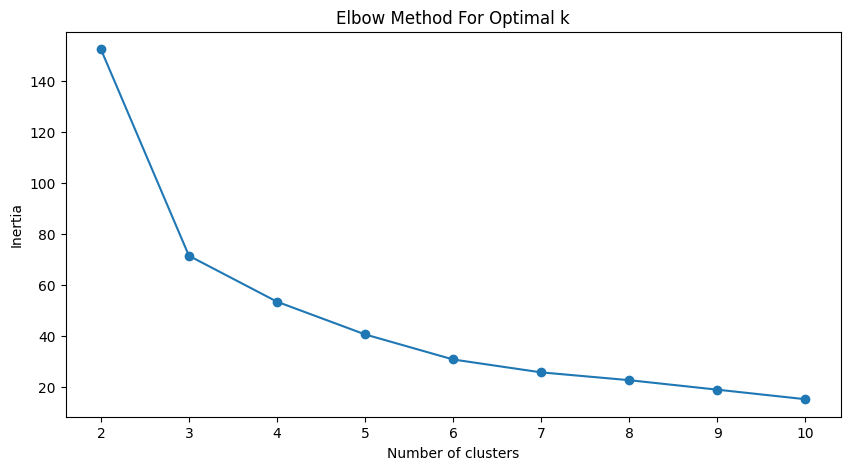

In [ ]:
#!pip install -U scikit-learn threadpoolctl

inertia = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=0)
    kmeans.fit(data_for_clustering_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Based on the line diagram in the diagram, I chose a K value of 3 as reasonable

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


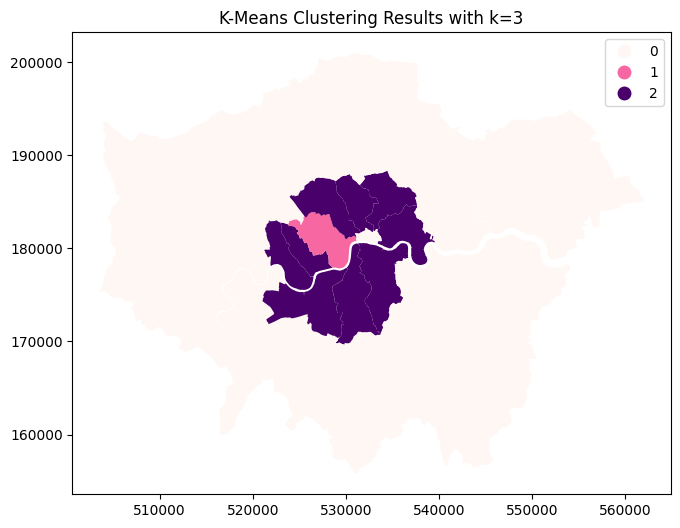

In [ ]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(data_for_clustering_scaled)

gdf_boroughs['cluster'] = clusters

fig, ax = plt.subplots(figsize=(10, 6))
gdf_boroughs.plot(column='cluster', categorical=True, legend=True,cmap='RdPu', ax=ax)
ax.set_title('K-Means Clustering Results with k=3')
plt.show()

In [ ]:
for cluster_num in range(k):
    boroughs_in_cluster = gdf_boroughs.loc[gdf_boroughs['cluster'] == cluster_num, 'NAME']
    print(f"Boroughs in cluster {cluster_num}:")
    print(boroughs_in_cluster.to_list())
    print("\n")


Boroughs in cluster 0:
['Kingston upon Thames', 'Croydon', 'Bromley', 'Hounslow', 'Ealing', 'Havering', 'Hillingdon', 'Harrow', 'Brent', 'Barnet', 'Lewisham', 'Greenwich', 'Bexley', 'Enfield', 'Waltham Forest', 'Redbridge', 'Sutton', 'Richmond upon Thames', 'Merton', 'Haringey', 'Newham', 'Barking and Dagenham', 'City of London']


Boroughs in cluster 1:
['Westminster']


Boroughs in cluster 2:
['Lambeth', 'Southwark', 'Wandsworth', 'Hammersmith and Fulham', 'Kensington and Chelsea', 'Camden', 'Tower Hamlets', 'Islington', 'Hackney']




***Cluster 0 represents areas with lower Airbnb density that have lower nighttime economic activity. For these areas, recommendations include:
Encouraging the development of Airbnb, especially if these areas are close to tourist attractions or have distinctive cultural backgrounds, may help to increase the activity of the night-time economy.
Recommend improvements to infrastructure, such as traffic and safety, to attract more nocturnal activities and visitors to local policy makers.***

***Cluster 1 represents areas with moderate Airbnb density, with some degree of nighttime economic activity. Recommendations for these areas include:
Support for small businesses and services in the night economy, such as catering and entertainment services, to further boost the economy.
Consider hosting events such as night markets or cultural festivals in these areas to promote community engagement and the growth of the night economy.***

***Cluster 2  represent areas with high Airbnb density that are hot spots for the nighttime economy. Recommendations for these areas include:
Regulate Airbnb's growth to ensure its impact on local housing markets is sustainable, while ensuring that community services are not overstretched by increased visitors.
More support for night workers, such as improved transport services and safety measures, to ensure the smooth running of economic activities at night.***